# Collision Detection Notebook
Implementation of 3D Collision Detection Algorithms

********************************************************************************************

In [19]:
import math
import shutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [20]:
from primitives.triangle import Triangle
from scenes.scene import Scene
from scenes.render import render_scene
from utils.misc import get_floor

/Users/dipanjan/anaconda3/envs/Primitive-Intersection/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


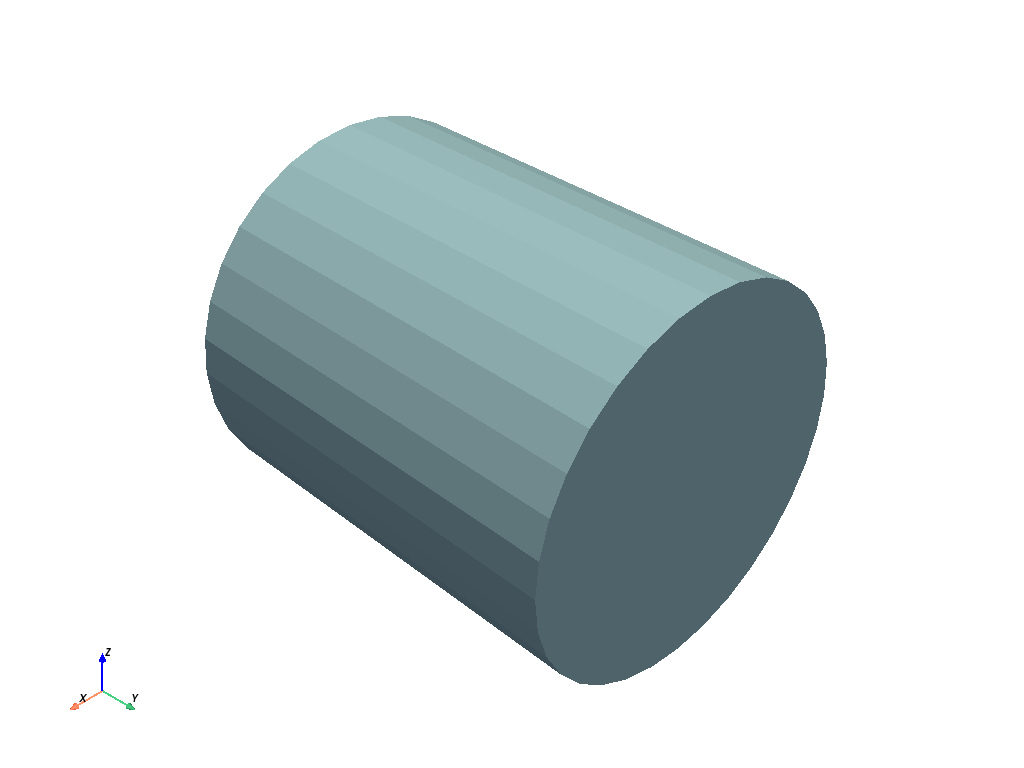

In [21]:
#load object
path = Path("objects/cylinder.obj").resolve()
mesh = pv.read(path)
mesh.plot()


In [22]:
mesh = mesh.triangulate()
points = np.ascontiguousarray(mesh.points)
points

array([[ 1.50000000e+00,  2.30000019e+00, -1.50000012e+00],
       [ 1.49999690e+00, -2.50000000e+00, -1.50000298e+00],
       [ 1.17853868e+00, -2.50000000e+00, -1.76381588e+00],
       [ 1.17854238e+00,  2.30000019e+00, -1.76381350e+00],
       [ 1.17854238e+00,  2.30000019e+00, -1.76381350e+00],
       [ 1.17853868e+00, -2.50000000e+00, -1.76381588e+00],
       [ 8.11789870e-01, -2.50000000e+00, -1.95984614e+00],
       [ 8.11794221e-01,  2.30000019e+00, -1.95984435e+00],
       [ 8.11794221e-01,  2.30000019e+00, -1.95984435e+00],
       [ 8.11789870e-01, -2.50000000e+00, -1.95984614e+00],
       [ 4.13844347e-01, -2.50000000e+00, -2.08056068e+00],
       [ 4.13849145e-01,  2.30000019e+00, -2.08055973e+00],
       [ 4.13849145e-01,  2.30000019e+00, -2.08055973e+00],
       [ 4.13844347e-01, -2.50000000e+00, -2.08056068e+00],
       [-4.96024131e-06, -2.50000000e+00, -2.12132025e+00],
       [ 1.72336712e-07,  2.30000019e+00, -2.12132025e+00],
       [ 1.72336712e-07,  2.30000019e+00

In [23]:
points = np.ascontiguousarray(mesh.points)
faces = mesh.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)

In [24]:
# Initialise an empty list for primitives
objects = numba.typed.List()

In [25]:
# Add the triangles in the list of objects
for v in vertices:
    a,b,c = v[0], v[1], v[2]

    triangle = Triangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64))
    objects.append(triangle)

objects

ListType[instance.jitclass.Triangle#15618b610<vertex_1:array(float64, 1d, A),vertex_2:array(float64, 1d, A),vertex_3:array(float64, 1d, A),centroid:array(float64, 1d, A),normal:array(float64, 1d, A)>]([<numba.experimental.jitclass.boxing.Triangle object at 0x281950df0>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950df0>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950df0>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950df0>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950df0>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950e50>, <numba.experimental.jitclass.boxing.Triangle object at 0x281950df0>, <numba.experimental.jitclass.boxing.Tri

In [26]:
from utils.vectors import normalize

# Calculate the bounding box of the point cloud
centroid = mesh.center

min_p = np.min(vertices)-5

centroid, min_p

([0.0, -0.09999990463256836, 0.0], -7.5)

In [27]:
# Define the camera parameters based on the bounding box
camera = centroid + np.array([0.0, 0.0, min_p])  # Position behind the centroid
look_at = normalize(centroid - camera)  # Looking towards the centroid
camera, look_at

(array([ 0.       , -0.0999999, -7.5      ]), array([0., 0., 1.]))

In [28]:
# Setup scene

# point camera
# look_at = np.array([0, 0, 1], dtype=np.float64)
# camera = np.array([1, 1, -5], dtype=np.float64)


# screen
width=300
height=300


# Initialise the scene with lights and camera
scene = Scene(look_at=look_at, camera=camera, width=width, height=height)

In [29]:
from accelerators.bvh import BoundedBox

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(objects)):
    bounded_boxes.append(BoundedBox(objects[i], i))

len(objects), len(bounded_boxes)

(128, 128)

In [30]:
from accelerators.bvh import build_bvh

# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)
ordered_prims = []
total_nodes = 0
root, bounded_boxes, ordered_prims, total_nodes = build_bvh(objects, bounded_boxes, start, end, ordered_prims, total_nodes)
# swap the primitives array with the ordered list
primitives = ordered_prims
# root node of the bvh tree
root

In [31]:
from accelerators.bvh import LinearBVHNode

# create a linear representation of the bvh tree
linear_nodes = numba.typed.List()
for _ in range(total_nodes):
    linear_nodes.append(LinearBVHNode())
# linear_nodes = [LinearBVHNode() for _ in range(total_nodes)]
len(linear_nodes) # equals to the number of nodes in the original tree

255

In [32]:
from accelerators.bvh import flatten_bvh

# linear bvh
linear_bvh, off_set = flatten_bvh(linear_nodes, root, 0)
len(linear_bvh)

255

In [33]:
# check if indexes of all primitives present in the linear bvh tree
total = 0
for _bvh in linear_bvh:
    total+= _bvh.n_primitives
total # should be equal to the number of primitives

128

In [34]:
# from primitives.ray import Ray
# from utils.misc import hit_object
# from utils.constants import ZEROS, BLUE
#
# start = time.time()
# # primitives = spheres, triangles
# image = render_scene(scene, objects, linear_bvh)
# end = time.time()
# print("Elapsed (with compilation) = %s" % (end - start))

In [35]:
from numba_progress import ProgressBar

num_iterations = scene.height

start = time.time()

with ProgressBar(total=num_iterations, ncols=80) as numba_progress1, ProgressBar(total=num_iterations, ncols=80) as numba_progress2:
    image = render_scene(scene, objects, linear_bvh, (numba_progress1, numba_progress2))

end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Elapsed (with compilation) = 0.4808387756347656


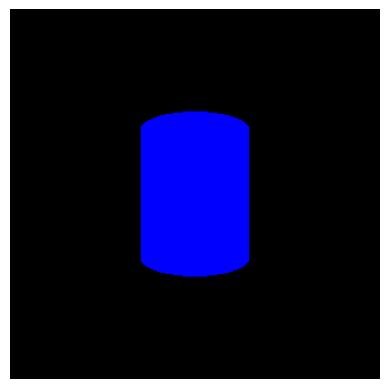

In [36]:
plt.imshow(image)
plt.axis('off')
plt.show()